In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)
df = pd.read_csv("./stack-overflow-developer-survey-2024/survey_results_public.csv")

Let's start with some EDA.

In [2]:
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have never visited Stack Overflow or the Sta...,NaN,NaN,NaN,NaN,NaN,Yes,Very favorable,Increase productivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,API document(s) and/or SDK document(s);User gu...,20,17,"Developer, full-stack",NaN,NaN,NaN,NaN,NaN,United Kingdom of Great Britain and Northern I...,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,PostgreSQL,PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,Express;Htmx;Node.js;React;Remix,Express;Node.js;React,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,MacOS;Windows,MacOS,NaN,NaN,NaN,Microsoft Teams;Slack,Slack,Slack,NaN,NaN,NaN,Stack Overflow for Teams (private knowledge sh...,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, definitely","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Individual contributor,17.0,Agree,Disagree,Agree,Agree,Agree,Neither agree nor disa

<Axes: >

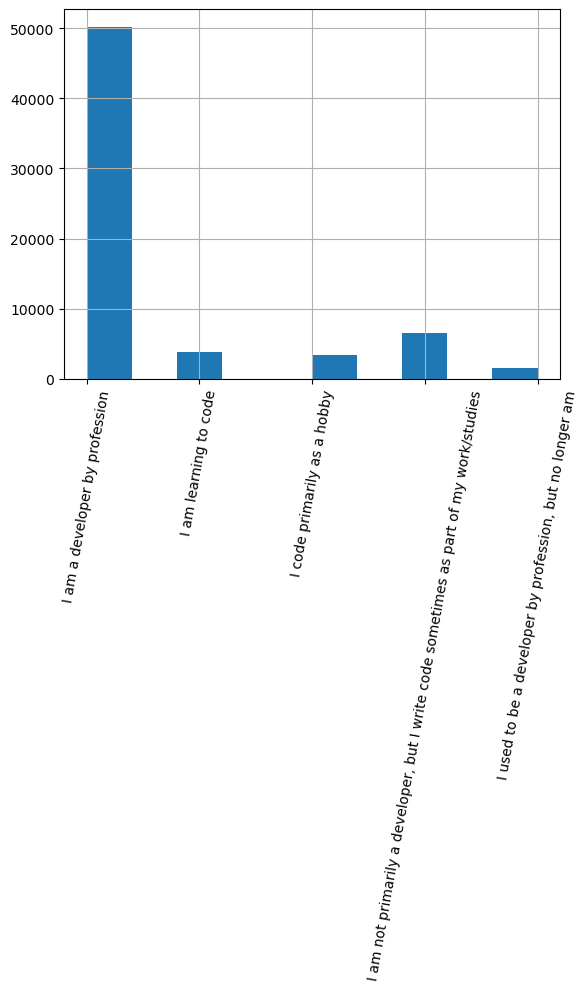

In [3]:
# How is the group of participants composed?
df['MainBranch'].hist( xrot=80)

<Axes: >

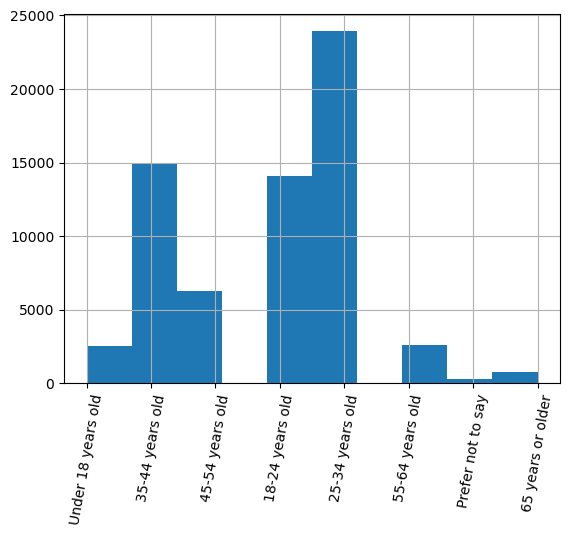

In [4]:
df['Age'].hist( xrot=80)
# Most participants are between 18 and 44 years old.

In [5]:
df['Employment'].describe()
# high number of unique values

count                   65437
unique                    110
top       Employed, full-time
freq                    39041
Name: Employment, dtype: object

<Axes: >

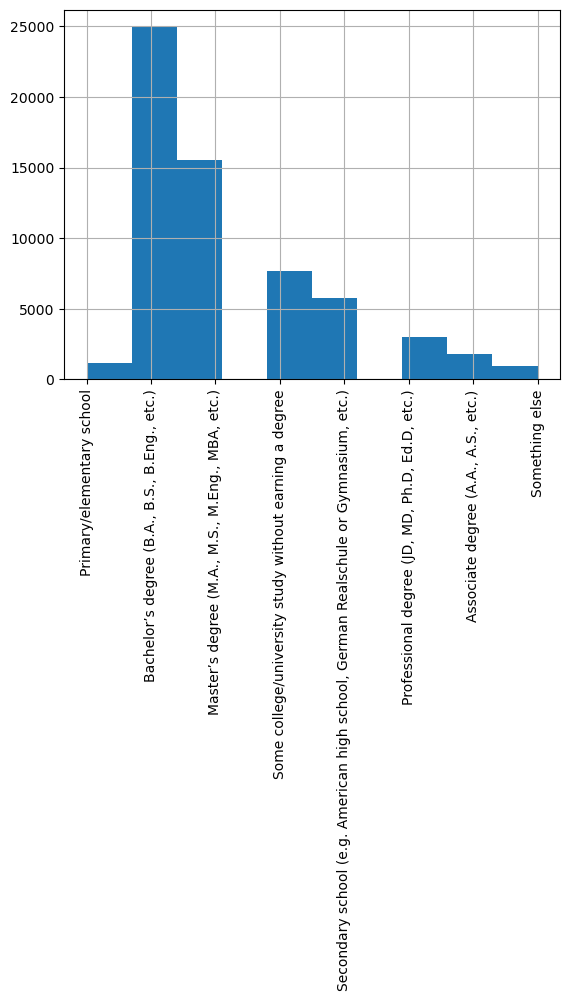

In [6]:
df['EdLevel'].hist( xrot=90)
# Most participants own a Bachelors or Maters degree

<Axes: >

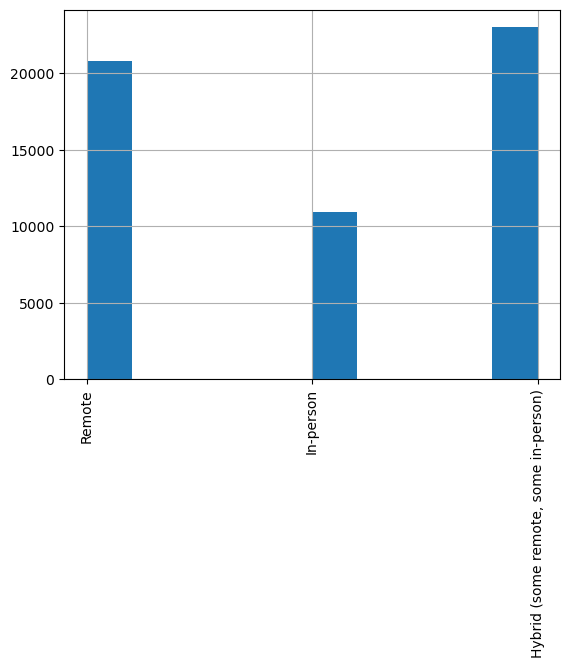

In [7]:
df['RemoteWork'].hist( xrot=90)
# a large amount of people work at leat some amount remote

<Axes: >

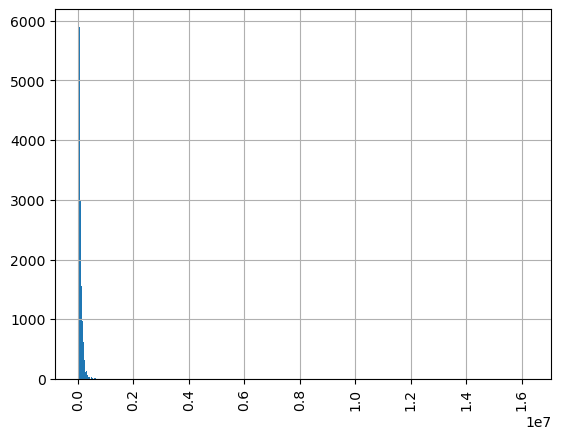

In [8]:
df['ConvertedCompYearly'].hist( xrot=90, bins =500)
# The distribution of ConvertedCompYearly (annual compensation) is highly right-skewed, which is typical for salary data.

<class 'pandas.core.series.Series'>
RangeIndex: 65437 entries, 0 to 65436
Series name: JobSat
Non-Null Count  Dtype  
--------------  -----  
29126 non-null  float64
dtypes: float64(1)
memory usage: 511.4 KB


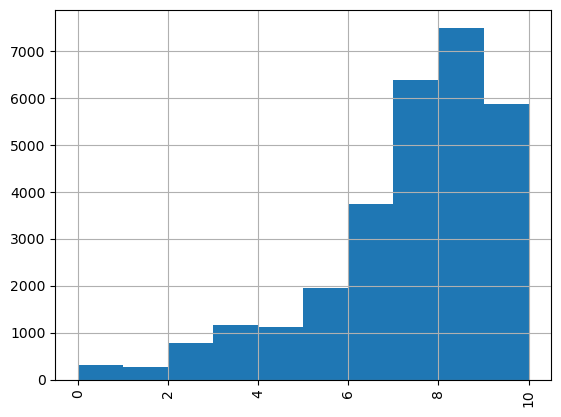

In [9]:
df['JobSat'].hist( xrot=90, bins =10)
# Most respondents are either satisfied or neutral with their job. 
# Fewer respondents reported being very dissatisfied or very satisfied.
# The JobSat column has 65437 - 29126 = 36,311 missing values, which could represent nearly half of the dataset.
df['JobSat'].info()

<Axes: >

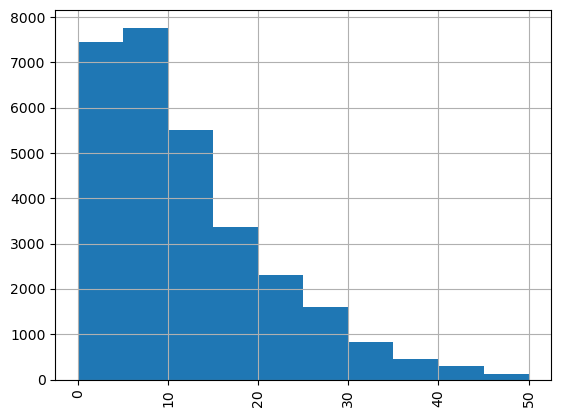

In [10]:
df['WorkExp'].hist( xrot=90, bins =10)
# The distribution of WorkExp (years of professional experience) is right-skewed, 
# meaning most respondents have relatively few years of experience, while a smaller number have many years.

In [11]:

selfdescription_dict = {'I am a developer by profession' : 5, 'I used to be a developer by profession, but no longer am': 4, 'I am not primarily a developer, but I write code sometimes as part of my work/studies': 3, 'I code primarily as a hobby':2, 'I am learning to code': 1, 'None of these': 0}
df['MainBranch'] = df['MainBranch'].replace(selfdescription_dict)

age_dict = {'Under 18 years old' : 0, '18-24 years old': 18, '25-34 years old': 25, '35-44 years old': 35, '45-54 years old': 45, '55-64 years old': 55, '65 years or older': 65, 'Prefer not to say': np.nan }
df['Age'] = df['Age'].replace(age_dict)

df = df.drop(columns=['CompTotal'])

In [12]:
education_dict = {'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 6, 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)' : 5, 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 4, 'Associate degree (A.A., A.S., etc.)': 3, 'Some college/university study without earning a degree':2, 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 1, 'Primary/elementary school': 0, 'Something else': 3}
df['EdLevel'] = df['EdLevel'].replace(education_dict)

df['YearsCode'] = df['YearsCode'].replace({
    'Less than 1 year': 0,
    'More than 50 years': 60
}).apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

df['YearsCodePro'] = df['YearsCodePro'].replace({
    'Less than 1 year': 0,
    'More than 50 years': 60
}).apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

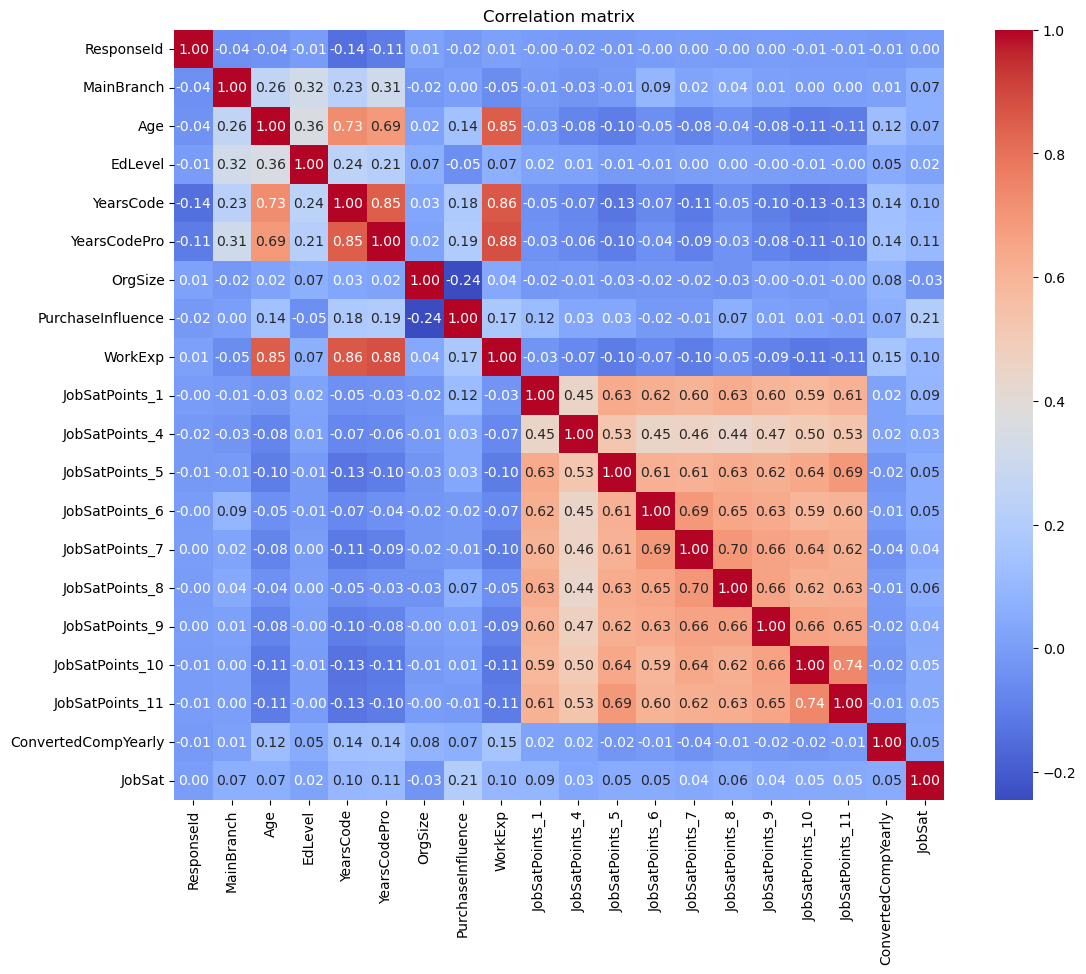

In [13]:
orgsize_dict = {'Just me - I am a freelancer, sole proprietor, etc.': 1, '2 to 9 employees' : 2, '10 to 19 employees': 10, '20 to 99 employees': 20, '100 to 499 employees': 100, '500 to 999 employees': 500, '1,000 to 4,999 employees': 1000, '5,000 to 9,999 employees': 5000, '10,000 or more employees': 10000, 'I don’t know': np.nan}
df['OrgSize'] = df['OrgSize'].replace(orgsize_dict)
df['OrgSize'].fillna(df['OrgSize'].mean(), inplace=True)

infl_dict = {'I have little or no influence': 0, 'I have some influence': 1, 'I have a great deal of influence': 2}
df['PurchaseInfluence'] = df['PurchaseInfluence'].replace(infl_dict)

corr = df.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.show()


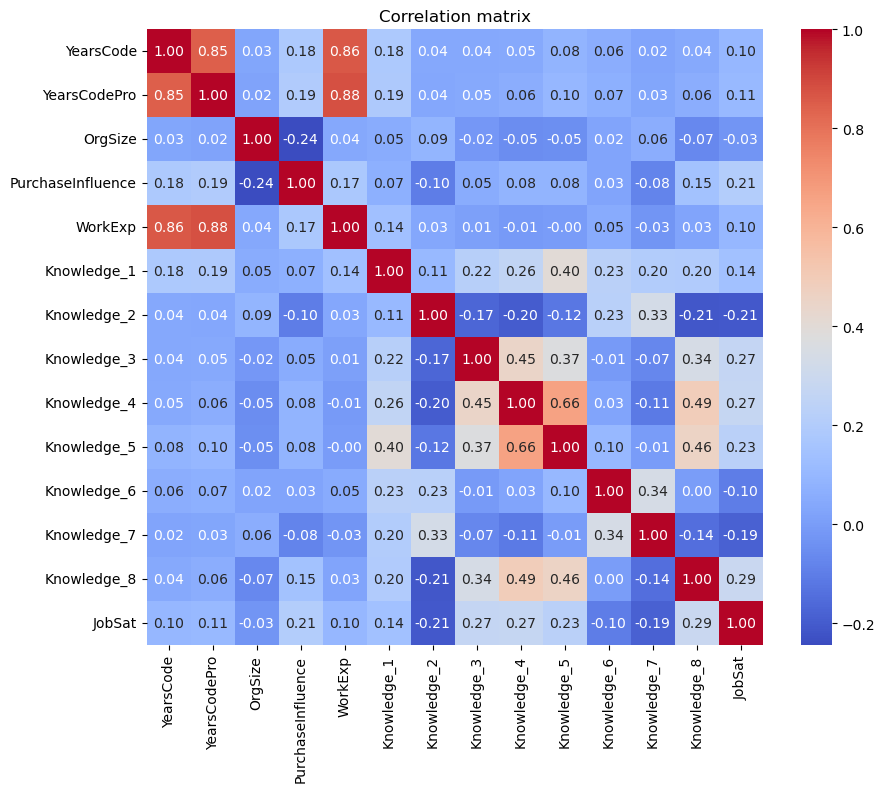

In [35]:
df1 = df[['YearsCode', 'YearsCodePro', 'OrgSize', 'PurchaseInfluence', 'WorkExp', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8','JobSat']]
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.show()

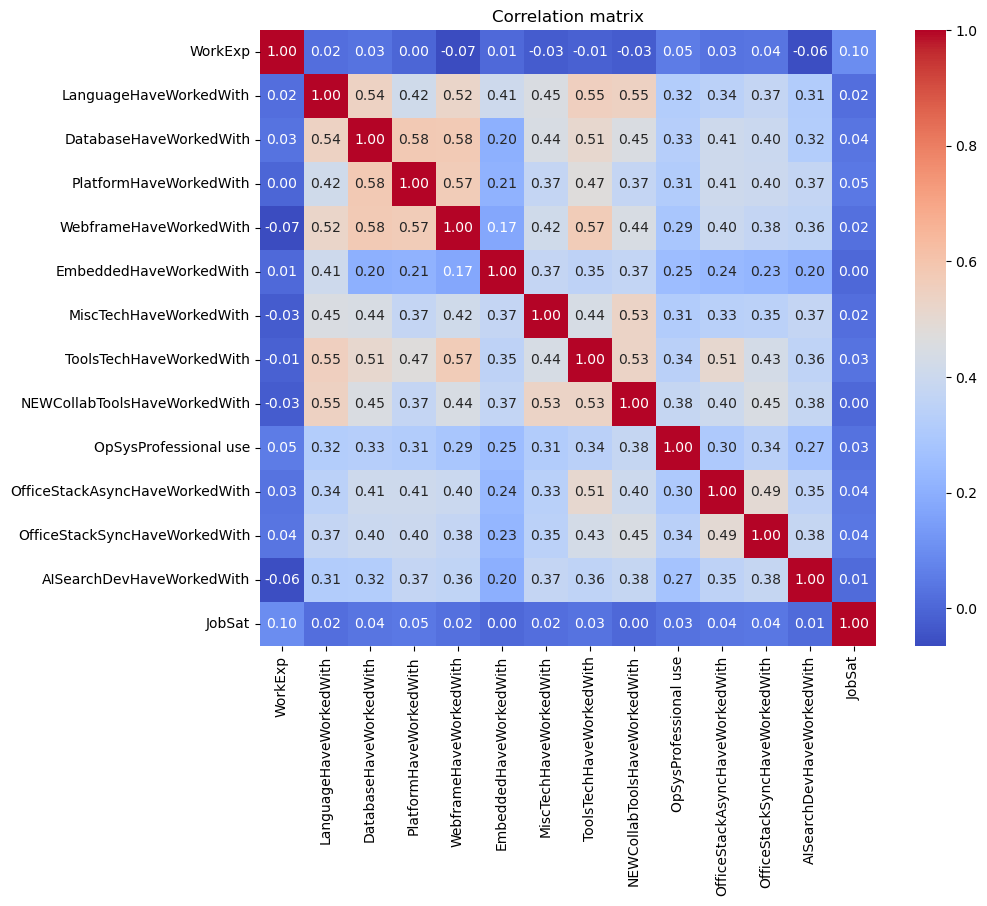

In [15]:
categories = ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'EmbeddedHaveWorkedWith', 'MiscTechHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith', 'OfficeStackSyncHaveWorkedWith', 'AISearchDevHaveWorkedWith']
for i in categories: 
    df[i] = df[i].apply(lambda x: str(x).count(';')+1)


df2 = df[['WorkExp', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 
          'EmbeddedHaveWorkedWith', 'MiscTechHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 
          'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith', 'OfficeStackSyncHaveWorkedWith', 'AISearchDevHaveWorkedWith', 'JobSat']]
corr = df2.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.show()

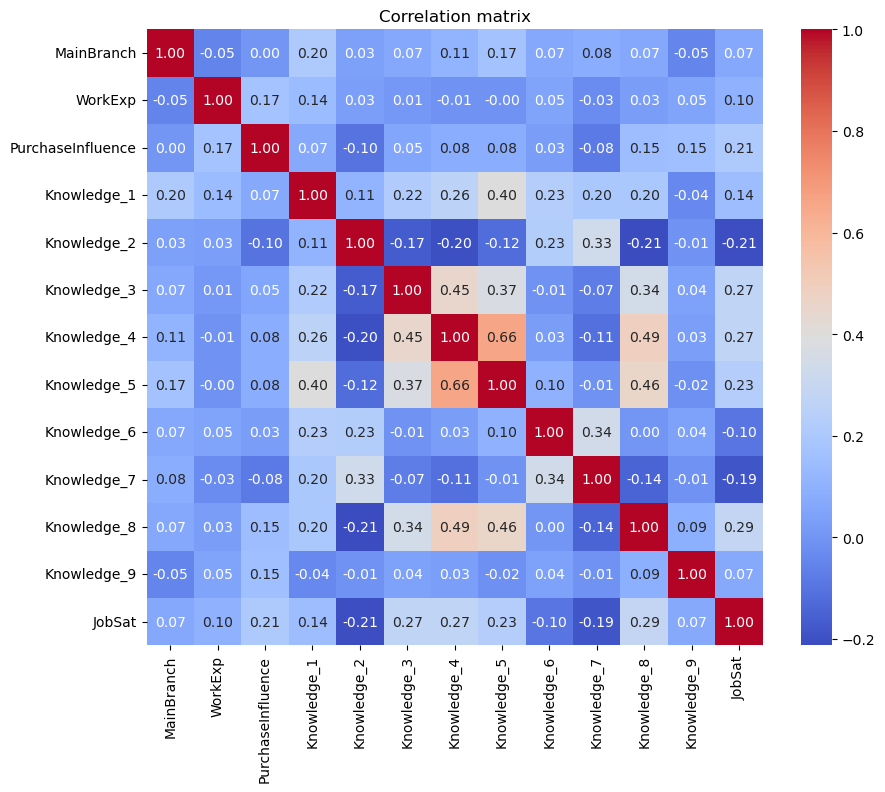

In [33]:
knowledge_dict = {'Agree':1, 'Strongly agree': 2,  'Neither agree nor disagree': 0,  'Disagree': -1, 
 'Strongly disagree': -2, np.nan: 0}

for i in list(range(1, 10)): 
    df['Knowledge_'+str(i)] = df['Knowledge_'+str(i)].replace(knowledge_dict)

df3 = df[['MainBranch', 'WorkExp', 'PurchaseInfluence', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'JobSat']]
corr = df3.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.show()

In [19]:
df['JobSat'].describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 113 entries, ResponseId to JobSat
dtypes: float64(25), int64(16), object(72)
memory usage: 56.4+ MB


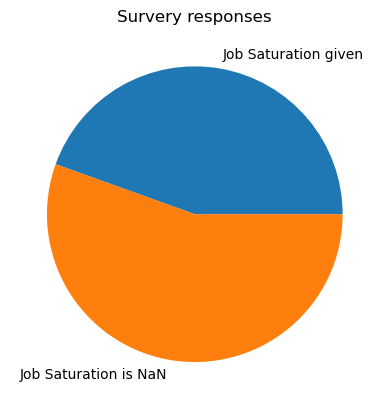

In [22]:
x = [65437-df['JobSat'].isna().sum(), df['JobSat'].isna().sum()]
labels = ['Job Saturation given', 'Job Saturation is NaN']

fig, ax = plt.subplots()
ax.pie(x, labels = labels)
ax.set_title('Survery responses')
plt.show()

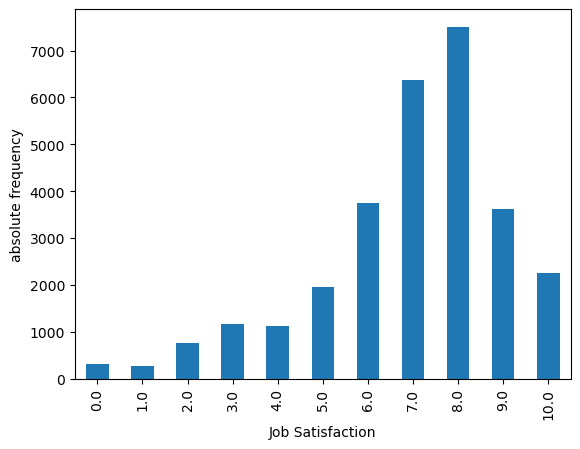

<Axes: >

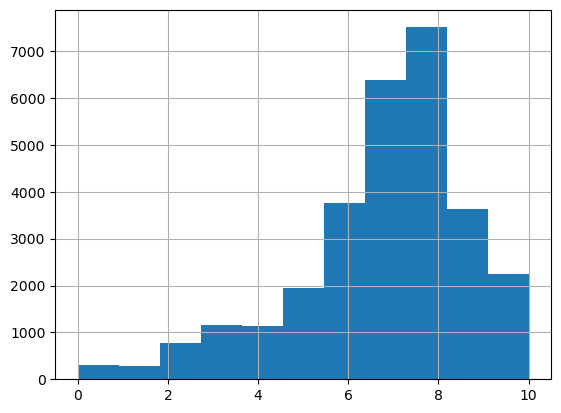

In [31]:
df['JobSat'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Job Satisfaction')
plt.ylabel('absolute frequency')
plt.show()

df['JobSat'].hist(bins=11)